# Import of Libs

In [1268]:
from PIL import Image
import numpy as np
import stumpy
import math
from os import listdir
from os.path import isfile, join, realpath
import json

## Definition of constants

In [1269]:
IMGPATH = "sample8.png"
DATASETPATH = "./dataset/trainingData/"
SETS = ["majuscules", "minuscules", "numericals", "specials"]
#SETS = ["t"]
OUTPUTFILE = "./output.json"
GRADE = 200
GRAYSCALE = [0.2989, 0.5870, 0.1140]

## Definition of variables

In [1270]:
img = None # original image
chanels = [] # list of chanels
selectedChanel = []
grayScaleChanels = [] # list of grayscaled chanels
firstLineRow = None # defines the 1st line where a black dot is detected
rawLines = dict() # contains rows where black dots are spotted and the column of the black dot. The key is the row and the value is a list of columns
spotedLines = [] # start and ending row for each detected line
rowsLetters = [] # separated letter boundaries [tl, tr, br, bl]
normalizedLetters = [] # normalized letters
binarizedChars = [] # binarized matrix of the characters

## Opening the image with Pillow

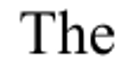

In [1271]:
img = Image.open(IMGPATH)
display(img)

## 2.1 Grayscaling
### Formula: Y = 0.2989R+0.5870G+0.1140B

### 1. Convertion of the image into a list of matrices each one representing R, G, B and alpha

In [1272]:
chanels = np.array(img)

### 2. Function to convert the matrix in to a level of GrayScale

In [1273]:
def grayScale(matrix, scale):
    grayImage = np.zeros(matrix.shape)
    R = np.array(matrix[:, :, 0])
    G = np.array(matrix[:, :, 1])
    B = np.array(matrix[:, :, 2])

    R = (R * scale[0])
    G = (G * scale[1])
    B = (B * scale[2])

    Y = R+G+B

    for i in range(3):
       grayImage[:,:,i] = Y

    return Image.fromarray(np.uint8(grayImage))


#### Converting the list of matrices in to a grayscale

In [1274]:
grayScaleChanels = grayScale(chanels, [0.2989, 0.5870, 0.1140]) 

## 2.2 Feature Extraction

In [1275]:
chanel = np.array(grayScaleChanels)[:, :, 0]

#### Display of the selected chanel converted into grayscale

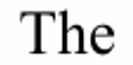

In [1276]:
display(Image.fromarray(chanel))

##### finds the first line where a black dot is spotted

In [1277]:
def spotFirstLineRow(chanel, grade):
    blackDots = []
    for x in range(len(chanel)):
        for y in range(len(chanel[x])):
            if chanel[x][y] >= grade:
                blackDots.append(x)
    return min(blackDots)

In [1278]:
firstLineRow = spotFirstLineRow(chanel, GRADE)

##### removes blank gaps between lines and creates segments

In [1279]:
def remblankLines(chanel, grade, startingRow):
    blackDottedLines = dict()
    for x in range(startingRow, len(chanel)):
        blackDots = []
        for y in range(len(chanel[x])):
            if chanel[x][y] < grade:
                blackDots.append(y)
        blackDottedLines[x] = blackDots
    
    copyOfBlackDottedLines = blackDottedLines.copy()
    for row, cols in blackDottedLines.items():
        if cols==[]:
            del copyOfBlackDottedLines[row]
    return copyOfBlackDottedLines

In [1280]:
rawlinesRows = remblankLines(chanel, GRADE, firstLineRow).keys()
rawlinesRows = list(rawlinesRows)

##### segments lines

In [1281]:
def findLinePositions(rawLinesRows):
    linesRows = []
    start = rawLinesRows[0]
    end = start
    for index, line in enumerate(rawlinesRows):
        if index == 0:
            continue
        if rawlinesRows[index-1]+1 != rawlinesRows[index]:
            end = rawlinesRows[index-1]
            linesRows.append((start, end))
            start = rawlinesRows[index]
        if len(rawLinesRows)-1 == index:
            linesRows.append((start, rawlinesRows[index]))
    return linesRows

In [1282]:
spotedLines = findLinePositions(rawlinesRows)

##### spot gaps between letters on a single line

In [1283]:
def spotLineEmptyCols(line, chanel, grade):
    cols = []
    for col in range(len(chanel[0])):
        whiteCols = []
        for currentRow in range(line[0], line[1]+1):
            if chanel[currentRow][col] > grade:
                whiteCols.append(col)
        cols.append(whiteCols)
        
    emptyCols = cols.copy()
    for col in cols:
        if len(col) < line[1]-line[0] + 1:
            emptyCols.remove(col)
            
    cols = []
    for listFromCol in emptyCols:
        cols.append(listFromCol[0])
    return cols

In [1284]:
rowsBlankSpaces = []              
for line in spotedLines:
    empty = spotLineEmptyCols(line, chanel, 128)
    rowsBlankSpaces.append((line, empty))

rowsBlankSpaces

[((9, 55),
  [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   55,
   56,
   57,
   58,
   87,
   88,
   89,
   90,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132])]

#### spot letters boundaries

In [1285]:
def rowLettersBoundaries(rowBlankSpace):
    letters = [] # col references of the columns
    letterCols = [] # current letter columns
    lettersMatrices = [] # set of letters
    letterMatrix = [] # top left, top right, bottom right and bottom left of the letter
    for col in range(len(chanel[0])):
        if col in rowBlankSpace[1]:
            if letterCols != []:
                letters.append(letterCols)
            letterCols = []
        else:
            letterCols.append(col)

    rows = rowBlankSpace[0]
    for letterCols in letters:
        letterMatrix.append((rows[0], letterCols[0]))
        letterMatrix.append((rows[0], letterCols[len(letterCols)-1]))
        letterMatrix.append((rows[len(rows)-1], letterCols[len(letterCols)-1]))
        letterMatrix.append((rows[len(rows)-1], letterCols[0]))

        lettersMatrices.append(letterMatrix)
        letterMatrix = []
    return lettersMatrices

In [1286]:
for rowBlankSpace in rowsBlankSpaces:
    rowsLetters.append(rowLettersBoundaries(rowBlankSpace))

rowsLetters

[[[(9, 20), (9, 54), (55, 54), (55, 20)],
  [(9, 59), (9, 86), (55, 86), (55, 59)],
  [(9, 91), (9, 113), (55, 113), (55, 91)]]]

### Normalization

In [1287]:
def normalizeCharacter(imageArray, top, bottom, left, right, isGray = False, target_size=(15, 15)):
    if isGray:
        cropped = np.array(imageArray)
    cropped = np.array(imageArray)[top:bottom, left:right]
    cropped_image = Image.fromarray(cropped)
    normalized_image = cropped_image.resize(target_size, Image.Resampling.LANCZOS)

    return np.array(normalized_image)

In [1288]:

for row in rowsLetters:
    for letter in row:
        normalizedLetters.append(normalizeCharacter(chanel, letter[0][0], letter[2][0], letter[0][1], letter[1][1],))

#saves croped characters
for index, letter in enumerate(normalizedLetters):
    Image.fromarray(letter).save("./test/" + str(index)+".png")

### Binarization of the character

In [1289]:
def binarize(character, grade):
    binarized = np.zeros(character.shape)
    for row in range(len(character)):
        for col in range(len(character[row])):
            if character[row][col]<=grade:
                binarized[row][col] = 1
    return binarized

In [1290]:

for index, letter in enumerate(normalizedLetters):
    binarizedChars.append(binarize(letter, 128))

## 2.3 Recognition of Pattern

### creates track sectors

In [1291]:
def trackSectors(binarizedChar):
    width, height = binarizedChar.shape
    centerY, centerX = width // 2, height // 2

    def pseudoY(centerY, row):
        Y = None
        Y = centerY - row
        if row < centerY:
            Y = - Y
        return Y
    
    def psuedoX(CenterX, col):
        X = None
        X = centerX - col
        if row < centerX:
            X = - X
        return X

    distances = []
    for row in range(len(binarizedChar)):
        Y = pseudoY(centerY, row)
        for col in range(len(binarizedChar[row])):
            X = psuedoX(centerX, col)
            distances.append(np.sqrt((X - centerX)**2 + (Y - centerY)**2))
    rad = max(distances)

    print(rad)

    #size of the tracks
    trackSize = rad / 5

    sectors = []
    for trackNumer in range(5):
        sector = []
        for row in range(len(binarizedChar)):
            Y = pseudoY(centerY, row)
            for col in range(len(binarizedChar[row])):
                X = psuedoX(centerX, col)
                distance = np.sqrt((X - centerX)**2 + (Y - centerY)**2)
                angle = math.atan(Y/X)
                if trackSize * trackNumer < distance and distance <= trackSize * (trackNumer + 1):
                    sector.append(binarizedChar[row][col])
        sectors.append(sector)

    print(sectors)
    return sectors
            

In [ ]:
def trackSectors(binarized_char):
    height, width = binarized_char.shape
    center_y, center_x = height // 2, width // 2

    # Calculate maximum radius (distance from center to farthest pixel)
    max_distance = np.sqrt(center_x**2 + center_y**2)

    # Define track size
    track_size = max_distance / 5

    # Initialize sectors: 5 tracks, each divided into 8 angular sections
    sectors = [[0 for _ in range(8)] for _ in range(5)]

    for row in range(height):
        for col in range(width):
            if binarized_char[row][col] == 1:  # Only consider black pixels
                # Compute distance and angle
                delta_y = row - center_y
                delta_x = col - center_x
                distance = np.sqrt(delta_x**2 + delta_y**2)
                angle = math.atan2(delta_y, delta_x)  # Angle in radians

                # Normalize angle to [0, 2π]
                if angle < 0:
                    angle += 2 * math.pi

                # Determine track index (0-4)
                track_idx = int(distance // track_size)

                # Determine sector index (0-7)
                sector_idx = int((angle / (2 * math.pi)) * 8)

                # Update the count in the corresponding track-sector
                if track_idx < 5:  # Ignore points outside the max radius
                    sectors[track_idx][sector_idx] += 1

    return sectors


In [1293]:
for char in binarizedChars:
    sectors = track_sectors(char)
    print(sectors)
    break

[[2, 1, 1, 0, 0, 0, 1, 1], [0, 2, 2, 0, 0, 0, 4, 0], [0, 2, 2, 0, 0, 1, 4, 0], [0, 4, 4, 0, 1, 5, 6, 0], [0, 0, 0, 0, 1, 1, 0, 3]]


## 2.4 Recognition of Output

#### data set: https://github.com/MinhasKamal/AlphabetRecognizer/tree/master

In [1294]:
def selectChanel(imagePath):
    # opening the image with PILLOW
    img = Image.open(imagePath)
    # chabels extraction
    chanels = np.array(img)
    # converting matrices into grayscale
    grayScaleChanels = grayScale(chanels, GRAYSCALE)
    # selection of a single channel
    selectedChanel = np.array(grayScaleChanels)[:, :, 0]
    return selectedChanel

#### Processing of the data set

In [ ]:
def charactersProcessor(img):
    chanels = [] # list of chanels
    selectedChanel = []
    grayScaleChanels = [] # list of grayscaled chanels
    firstLineRow = None # defines the 1st line where a black dot is detected
    rawLines = dict() # contains rows where black dots are spotted and the column of the black dot. The key is the row and the value is a list of columns
    spotedLines = [] # start and ending row for each detected line
    rowsLetters = [] # separated letter boundaries [tl, tr, br, bl]
    normalizedLetters = [] # normalized letters
    binarizedChars = [] # binarized matrix of the characters
    tracks = []
    charTracks = []

    selectedChanel = selectChanel(img)
    # finds the first row
    firstLineRow = spotFirstLineRow(selectedChanel, GRADE)
    # detection of raw lines
    rawlinesRows = remblankLines(selectedChanel, GRADE, firstLineRow).keys()
    rawlinesRows = list(rawlinesRows)
    # finds lines positions
    spotedLines = findLinePositions(rawlinesRows)
    # segment letters of the line
    rowsBlankSpaces = []              
    for line in spotedLines:
        empty = spotLineEmptyCols(line, selectedChanel, 128)
        rowsBlankSpaces.append((line, empty))

    for rowBlankSpace in rowsBlankSpaces:
        rowsLetters.append(rowLettersBoundaries(rowBlankSpace))

    # normalize characters
    for row in rowsLetters:
        for letter in row:
            normalizedLetters.append(normalizeCharacter(chanel, letter[0][0], letter[2][0], letter[0][1], letter[1][1],))

    # binarize characters
    for index, letter in enumerate(normalizedLetters):
        binarizedChars.append(binarize(letter, GRADE))

        # print(np.array(binarizedChars).shape)

    # extract sectors
    for char in binarizedChars:
        charTracks.append(trackSectors(char))
    
    return charTracks

In [1296]:
def char2Track(path):
    # opening the image with PILLOW
    img = Image.open(path)
    # chabels extraction
    chanel = np.array(img)
    # normalize
    normalized = normalizeCharacter(chanel, 0, len(chanel), 0, len(chanel[0]), isGray=True)
    # binarize
    binarizedChar = binarize(normalized, GRADE)
    return track_sectors(binarizedChar)

In [1297]:
chars = dict()

for setPath in SETS:
    path = DATASETPATH+setPath
    path = realpath(path)
    
    for folder in listdir(path):
        newPath = realpath(path+"/"+folder+"/")
        charTracks = []
        for file in listdir(newPath):
            fullPath = join(newPath, file)
            if isfile(fullPath):
                res = char2Track(fullPath)
                charTracks.append(res)
        chars[folder] = charTracks

with open(OUTPUTFILE, "w") as f:
    json.dump(chars, f)



### Matrices Similarity comparison

In [1298]:
def matrix_hamming_distance(matrixA, matrixB):
    """
    Calculate the total Hamming distance between two 5x8 matrices.
    """
    if len(matrixA) != len(matrixB) or len(matrixA[0]) != len(matrixB[0]):
        print(f"{len(matrixA)}--{len(matrixB)}")
        print(f"{len(matrixA[0])}--{len(matrixB[0])}")
        raise ValueError("Matrices must have the same dimensions.")
    
    total_distance = 0
    for rowA, rowB in zip(matrixA, matrixB):
        total_distance += sum(a != b for a, b in zip(rowA, rowB))
    
    return total_distance


In [1299]:
with open(OUTPUTFILE, "r") as f:
    dataSet = json.loads(f.read())

    charsTracks = charactersProcessor(IMGPATH)

    result = "-"

    for charTracks in charsTracks:
        charScores = dict()
        for charName, tracks in dataSet.items():
            scores = []
            for track in tracks:
                score = matrix_hamming_distance(charTracks, track)
                scores.append(score)
            charScores[charName] = max(scores)
        print(charScores)
        s = list(charScores.values())
        maxScore = min(s)
        index = s.index(maxScore)
        result = result + list(charScores.keys())[index]
    
    print(result)




{'A': 37, 'B': 35, 'C': 37, 'D': 37, 'E': 36, 'F': 32, 'G': 36, 'H': 35, 'I': 28, 'J': 33, 'K': 32, 'L': 36, 'M': 37, 'N': 32, 'O': 34, 'P': 32, 'Q': 36, 'R': 34, 'S': 31, 'T': 22, 'U': 36, 'V': 34, 'W': 31, 'X': 31, 'Y': 24, 'Z': 30, 'a': 35, 'b': 34, 'c': 37, 'd': 37, 'e': 32, 'f': 29, 'g': 34, 'h': 36, 'i': 30, 'j': 35, 'k': 32, 'l': 31, 'm': 29, 'n': 39, 'o': 35, 'p': 36, 'q': 37, 'r': 35, 's': 29, 't': 31, 'u': 38, 'v': 31, 'w': 29, 'x': 31, 'y': 28, 'z': 31, '0': 34, '1': 32, '2': 36, '3': 32, '4': 36, '5': 33, '6': 30, '7': 29, '8': 34, '9': 33, '#': 34, '$': 29, '%': 33, '&': 35, '(': 35, ')': 33, ',': 30, ';': 34, '@': 35, 'colon': 35, 'dot': 26, 'exclamation mark': 29, 'question mark': 29, '[': 36, ']': 34, '{': 29, '}': 26}
{'A': 32, 'B': 31, 'C': 31, 'D': 30, 'E': 32, 'F': 34, 'G': 32, 'H': 32, 'I': 35, 'J': 35, 'K': 36, 'L': 29, 'M': 35, 'N': 35, 'O': 30, 'P': 36, 'Q': 37, 'R': 35, 'S': 33, 'T': 36, 'U': 30, 'V': 35, 'W': 35, 'X': 35, 'Y': 37, 'Z': 34, 'a': 33, 'b': 27, 'c

In [1300]:
def match(matrixA, matrixB):
    matrixA = np.array(matrixA,dtype=np.float64)
    matrixB = np.array(matrixB,dtype=np.float64)
    matrixA = matrixA.flatten()
    matrixB = matrixB.flatten()
    score = stumpy.match(matrixA, matrixB)
    return score
    

In [1305]:
# Load dataset from JSON file
with open(OUTPUTFILE, "r") as f:
    dataSet = json.loads(f.read())

# Process input image to extract character tracks
charsTracks = charactersProcessor(IMGPATH)

result = ""

# Compare each character track against the dataset
for inputTrack in charsTracks:
    charScores = {}

    # Iterate over dataset characters and their tracks
    for charName, datasetTracks in dataSet.items():
        scores = []
        for datasetTrack in datasetTracks:
            score = matrix_hamming_distance(inputTrack, datasetTrack)
            #print(max(list(match(inputTrack, datasetTrack)[0])))
            #score = max(list(match(inputTrack, datasetTrack).flatten()))
            scores.append(score)
        
        # Use the best score for this character
        if scores:
            charScores[charName] = max(scores)

    # Determine the character with the highest score
    if charScores:
        bestMatch = min(charScores, key=charScores.get)
        result += bestMatch

# Print the resulting matched characters
print("Resultat:", result)


Resultat: ThO
